In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
def generate_subsets(n):
    # Generate all possible subsets of size 1 to n.
    for size in range(1, n + 1):
        for subset in combinations(range(n), size):
            yield subset
            # print(subset)


def check_p(matrix):
    n = len(matrix)

    # Compute the determinant of the whole matrix first.
    determinant = np.linalg.det(matrix)
    if determinant <= 0:
        return False  # Return immediately if the whole matrix has a non-positive determinant

    # Check the determinants of diagonal elements (smallest subset) next.
    for i in range(n):
        submatrix = matrix[i, i]
        if submatrix <= 0:
            return False  # Return immediately if any diagonal element is non-positive

    # Initialize the generator to get subsets.
    subset_generator = generate_subsets(n)

    # Check the determinants of other subsets.
    for subset in subset_generator:
        if len(subset) > 1:
            submatrix = matrix[np.ix_(subset, subset)]
            determinant = np.linalg.det(submatrix)
            if determinant <= 0:
                return False  # Return immediately if a non-positive determinant is found

    return True # Return True if all determinants are positive


def generate_matrix(n):
    # Generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

In [18]:
# A = generate_matrix(4)
# print(np.linalg.eigvals(A - np.eye(4)))
# # print absolute values of eigenvalues
# print(np.abs(np.linalg.eigvals(A - np.eye(4))))


# print(np.min(np.linalg.eigvals(A - np.eye(4))))
# print(np.max(np.linalg.eigvals(A - np.eye(4))))

In [24]:
# import numpy as np
# import matplotlib.pyplot as plt
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5
# iterations = 5000
# strength_list = [2, 4, 8, 10]

# # Prepare the figure for 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# axs = axs.flatten()  # Flatten the axs array for easy indexing

# # Bar colors
# bar_color1 = 'plum'
# bar_color2 = 'indigo'

# # Lists to store success and false prediction rates for each strength
# percent_success_by_strength = [[] for _ in strength_list]
# percent_false_by_strength = [[] for _ in strength_list]


# # Loop through each strength value
# for idx, strength in enumerate(strength_list):
#     condition_true_counts = []
#     total_counts = []
#     total_all = []
#     false_positive_list = []

#     for n in n_list:
#         condition_true_count = 0
#         total_count = 0
#         total_count_all = 0
#         false_positive = 0

#         for i in range(iterations):
#             G1 = generate_matrix(n)
#             G2 = generate_matrix(n)*strength
#             # threshold = strength * 0.2
#             # G2[abs(G2) < threshold] = 0
#             np.fill_diagonal(G2, 1)
            
#             G = kappa * G1 + (1 - kappa) * G2
#             result1 = check_p(G1)
#             result2 = check_p(G2)
#             result = check_p(G)

#             lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
#             lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
#             condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * lambda_max_G1))

#             # Check the conditions for unique NEs
#             layer1_NE = result1 & (not result2)
#             layer2_NE = (not result1) & result2
        
#             if layer1_NE or layer2_NE:
#                 if not result:
#                     total_count += 1
#                     # Check condition for the matrices here
#                     if condition:
#                         condition_true_count += 1
#             # counting false predictions
#             if result:
#                 # total_count_all += 1
#                 if condition:
#                     false_positive += 1

                    
#         condition_true_counts.append(condition_true_count)
#         total_counts.append(total_count)
#         # total_all.append(total_count_all)
#         false_positive_list.append(false_positive)
    
#     # Calculate percentages for each 'n'
#     for total_count, condition_true_count, false_positive in zip(total_counts, condition_true_counts, false_positive_list):
#         success_rate = (condition_true_count / total_count * 100) if total_count else 0
#         false_rate = (false_positive / total_count * 100) if total_count else 0
#         percent_success_by_strength[idx].append(success_rate)
#         percent_false_by_strength[idx].append(false_rate)

#     # Plotting the bar graphs for this strength value
#     ax = axs[idx]
#     width = 0.4
#     x = np.arange(len(n_list))

#     ax.bar(x + width/2, total_counts, width, color=bar_color2)
#     ax.bar(x, condition_true_counts, width, color=bar_color1)
#     ax.bar(x - width/2, false_positive_list, width, color='deeppink')

#     ax.set_xlabel('Number of Nodes (n)')
#     ax.set_ylabel('Count')
#     ax.set_title(f'Relative Strength of Edges = {strength}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(n_list)

#     # Create a twin y-axis for the percentage plot
#     ax2 = ax.twinx()
#     # Adjust x-coordinates for line plot to align with the bar plots
#     line_x = x
#     ax2.plot(line_x, percent_success_by_strength[idx], marker='o', color='skyblue', label=f'Success Rate (Strength {strength})')
#     ax2.set_ylabel('Percentage (%)')

#     # Set the legend for the line plot
#     ax2.legend(loc='upper left')

# # Add legend for bar plots
# bar_labels = ['Multiplex networks without unique NE and a layer that has a unique NE', 'Successfully detected by Proposition 9', 'False predictions']
# fig.legend(bar_labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

# plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# # plt.savefig('multiplex-prop-neg.png', dpi=600)
# plt.show()

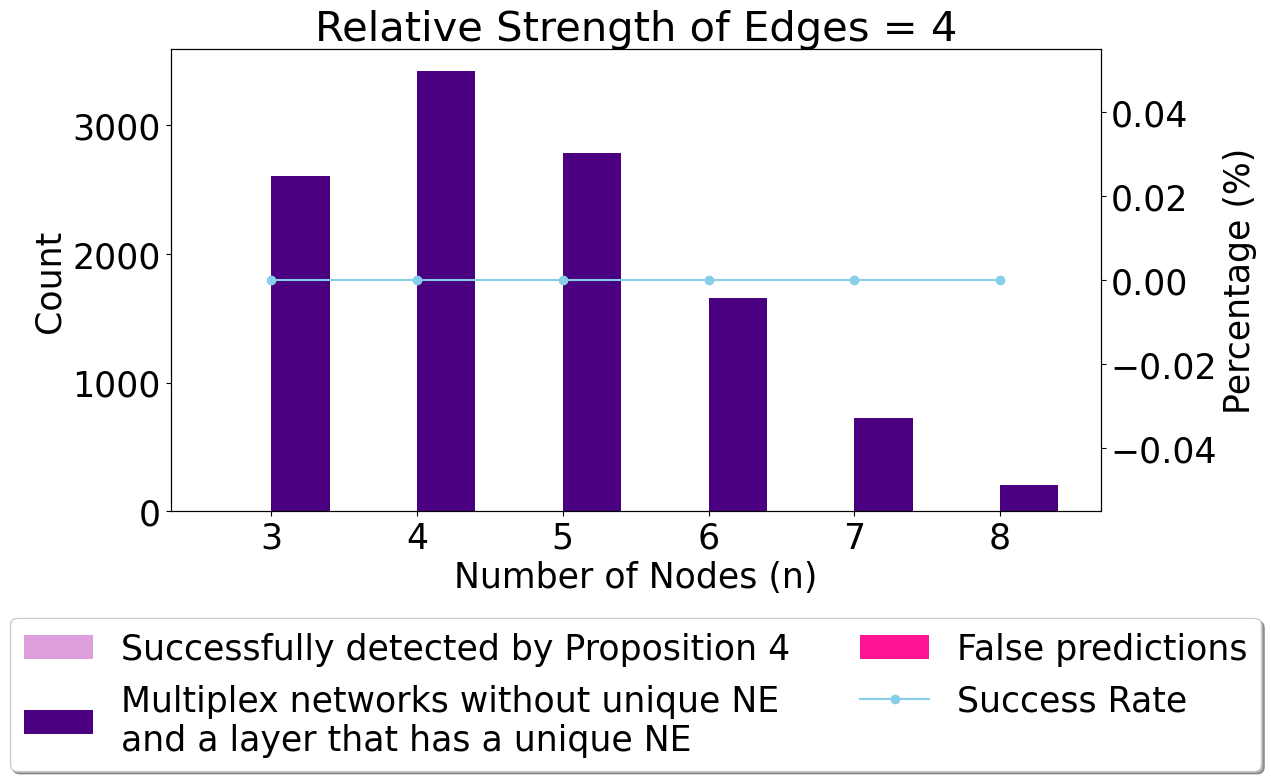

In [54]:
# FOR STRENGTH = 4
n_list = [3, 4, 5, 6, 7, 8]
kappa = 0.5
iterations = 5000
strength = 4  # Example strength value

plt.rcParams.update({'font.size': 25})  # Sets the default font size to 16

# Bar colors
bar_color1 = 'plum'
bar_color2 = 'indigo'

condition_true_counts = []
total_counts = []
false_positive_list = []

for n in n_list:
    condition_true_count = 0
    total_count = 0
    false_positive = 0

    for i in range(iterations):
        G1 = generate_matrix(n)
        G2 = generate_matrix(n) * strength
        # threshold = strength * 0.2
        # G2[abs(G2) < threshold] = 0
        np.fill_diagonal(G2, 1)
        
        G = kappa * G1 + (1 - kappa) * G2
        result1 = check_p(G1)
        result2 = check_p(G2)
        result = check_p(G)

        lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
        lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
        condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * abs(lambda_max_G1)))

        # Check the conditions for unique NEs
        layer1_NE = result1 & (not result2)
        layer2_NE = (not result1) & result2
    
        if layer1_NE or layer2_NE:
            if not result:
                total_count += 1
                # Check condition for the matrices here
                if condition:
                    condition_true_count += 1
        # counting false predictions
        if result:
            # total_count_all += 1
            if condition:
                false_positive += 1
                # print(G1)
                # print(G2)
                # print(G)
                # print('---')
                # # stop the loop
                # break

    condition_true_counts.append(condition_true_count)
    total_counts.append(total_count)
    false_positive_list.append(false_positive)

# Prepare the figure
plt.figure(figsize=(12, 6))

width = 0.4
x = np.arange(len(n_list))

bar2 = plt.bar(x + width/2, total_counts, width, color=bar_color2)
bar1 = plt.bar(x, condition_true_counts, width, color=bar_color1)
bar3 = plt.bar(x - width/2, false_positive_list, width, color='deeppink')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Count')
plt.title(f'Relative Strength of Edges = {strength}')
plt.xticks(x, n_list)

# Create a twin y-axis for the percentage plot
ax2 = plt.gca().twinx()

# Calculate percentages for each 'n'
percent_success = [(ctc / tc * 100) if tc else 0 for tc, ctc in zip(total_counts, condition_true_counts)]
percent_false = [(fp / tc * 100) if tc else 0 for tc, fp in zip(total_counts, false_positive_list)]

line_x = x
line_plot, = ax2.plot(line_x, percent_success, marker='o', color='skyblue', label='Success Rate')
ax2.set_ylabel('Percentage (%)')

# Set the legend for the bar plots and line plot
plt.legend([bar1, bar2, bar3, line_plot], 
           ['Successfully detected by Proposition 4', 
            'Multiplex networks without unique NE\nand a layer that has a unique NE', 
            'False predictions',
            'Success Rate'], 
           loc='lower center', bbox_to_anchor=(0.5, -0.6), shadow=True, ncol=2)


# plt.tight_layout()
# plt.savefig('multiplex-prop-neg.png', bbox_inches='tight', dpi=60)
plt.show()

In [58]:
n_list = [3, 4, 5, 6, 7, 8]
kappa = 0.5
iterations = 5000
strength_list = [1, 2, 3, 4, 5, 6, 7, 8]
percent_success_by_strength = [[] for _ in strength_list]

for strength in strength_list:
    condition_true_counts = []
    total_counts = []
    false_positive_list = []

    for n in n_list:
        condition_true_count = 0
        total_count = 0
        false_positive = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n) * strength
            # threshold = strength * 0.2
            # G2[abs(G2) < threshold] = 0
            np.fill_diagonal(G2, 1)
            
            G = kappa * G1 + (1 - kappa) * G2
            result1 = check_p(G1)
            result2 = check_p(G2)
            result = check_p(G)

            lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
            lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
            condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * abs(lambda_max_G1)))

            # Check the conditions for unique NEs
            layer1_NE = result1 & (not result2)
            layer2_NE = (not result1) & result2
        
            if layer1_NE or layer2_NE:
                if not result:
                    total_count += 1
                    # Check condition for the matrices here
                    if condition:
                        condition_true_count += 1
            # counting false predictions
            if result:
                # total_count_all += 1
                if condition:
                    false_positive += 1

        condition_true_counts.append(condition_true_count)
        total_counts.append(total_count)
        false_positive_list.append(false_positive)
        
    percent_success = [(ctc / tc * 100) if tc else 0 for tc, ctc in zip(total_counts, condition_true_counts)]
    percent_success_by_strength[strength_list.index(strength)].extend(percent_success)

In [59]:
print(percent_success_by_strength)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [9.327548806941431, 9.448818897637794, 10.731373889268626, 12.965964343598054, 16.46153846153846, 19.469026548672566], [34.34282253179891, 37.81226343679031, 46.56882189607299, 56.44471594379963, 68.22995461422087, 77.92207792207793], [57.19799305287534, 63.76093294460642, 72.6916221033868, 82.34234234234235, 87.92134831460675, 94.35897435897435], [73.86983007374158, 77.52106550693124, 86.29059829059828, 92.11618257261411, 95.44072948328267, 99.06976744186046], [81.67000285959394, 85.90673575129534, 91.81347150259067, 96.8503937007874, 97.84482758620689, 99.08675799086758], [86.71517111290757, 90.64267352185091, 95.74171029668412, 97.79141104294479, 99.71056439942113, 100.0], [89.76109215017065, 92.89866060146575, 96.91463832704834, 99.2154496077248, 99.26900584795322, 100.0]]


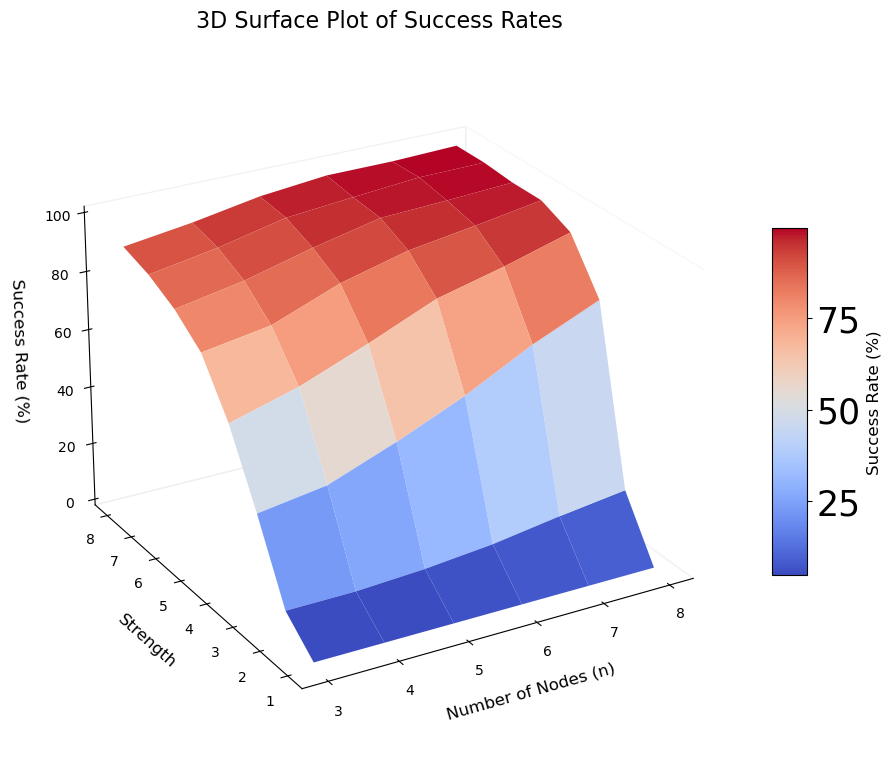

In [60]:
# Example data
n = np.array([3, 4, 5, 6, 7, 8])
strengths = np.array([1, 2, 3, 4, 5, 6, 7, 8])
success_rates = np.array(percent_success_by_strength)

# Create meshgrid for n and strengths
N, Strengths = np.meshgrid(n, strengths)

# Create 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with colormap and shading
surface = ax.plot_surface(N, Strengths, success_rates, cmap=cm.coolwarm, edgecolor='none', linewidth=0, antialiased=True)
surface.set_facecolor((1.0, 1.0, 1.0, 0))  # Transparent faces

# Lighting effect
ax.view_init(elev=25, azim=-120)  # Adjust viewing angle for better perspective

# Add color bar which maps values to colors
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Success Rate (%)', fontsize=12)

# Setting labels
ax.set_xlabel('Number of Nodes (n)', labelpad=10, fontsize=12)
ax.set_ylabel('Strength', labelpad=10, fontsize=12)
ax.set_zlabel('Success Rate (%)', labelpad=10, fontsize=12)

# Set title
ax.set_title('3D Surface Plot of Success Rates', pad=20, fontsize=16)

# Enhance tick labels size
ax.tick_params(axis='both', which='major', labelsize=10)

# Remove gridlines and background to make it cleaner
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Show plot
plt.savefig('multiplex-prop-neg-3d.png', dpi=60)
plt.show()


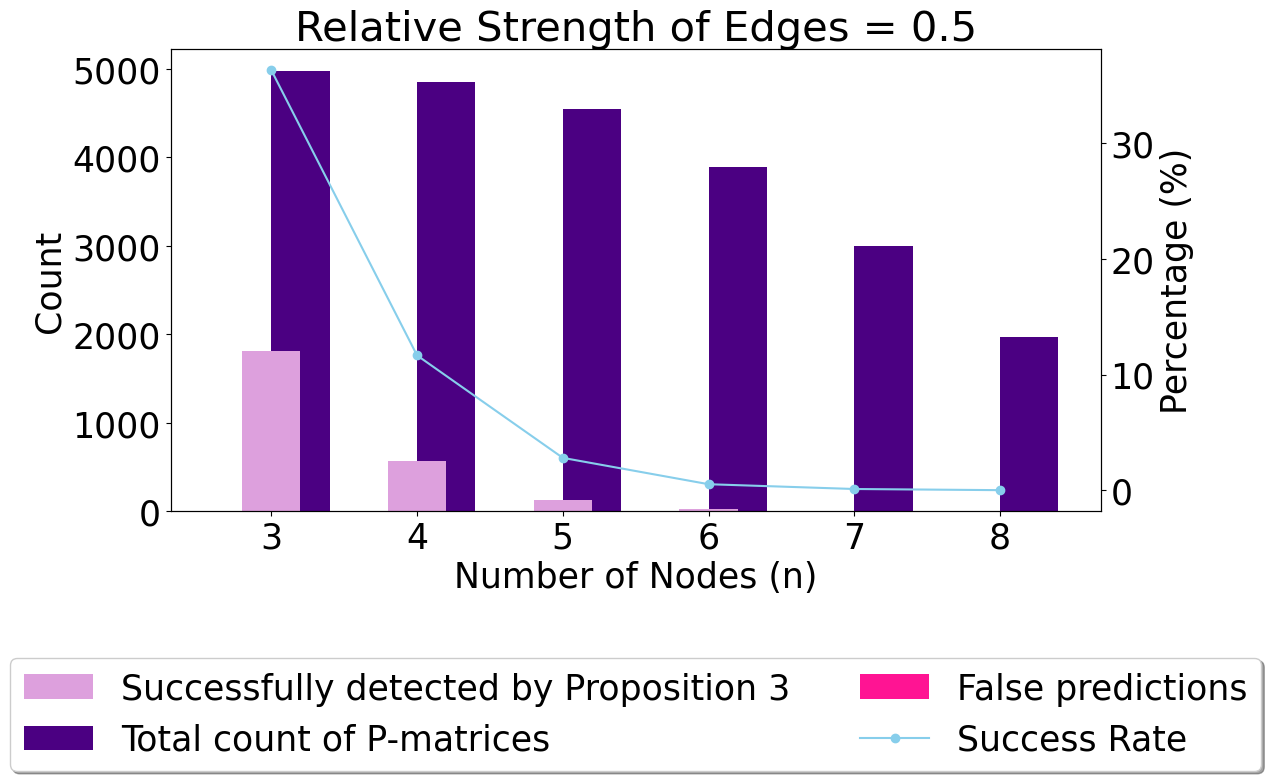

In [46]:
# FOR STRENGTH = 0.25
iterations = 5000
n_list = [3, 4, 5, 6, 7, 8]
kappa = 0.5
strength = 0.5  # Example strength value

plt.rcParams.update({'font.size': 25})  # Sets the default font size to 16

# Prepare the figure
plt.figure(figsize=(12, 6))

# Bar colors
bar_color1 = 'plum'
bar_color2 = 'indigo'

condition_help_list = []
p_matrix_total_list = []
false_negative_list = []

for n in n_list:
    condition_help_count = 0
    p_matrix_total_count = 0
    false_negative = 0

    for i in range(iterations):
        G1 = generate_matrix(n)
        G2 = generate_matrix(n) * strength
        G = kappa * G1 + (1 - kappa) * G2
        result = check_p(G)

        lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
        lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

        condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

        if condition & result:
            condition_help_count += 1
        if result:
            p_matrix_total_count += 1
        if condition & (not result):
            false_negative += 1
            # print(G1)
            # print(G2)
            # print(G)
            # print('---')
            # break
    
    condition_help_list.append(condition_help_count)
    p_matrix_total_list.append(p_matrix_total_count)
    false_negative_list.append(false_negative)

# Plotting
width = 0.4
x = np.arange(len(n_list))

bar2 = plt.bar(x + width/2, p_matrix_total_list, width, color=bar_color2, label='Total Count of P-Matrices')
bar1 = plt.bar(x, condition_help_list, width, color=bar_color1, label='Successfully Detected by Proposition 8')
bar3 = plt.bar(x - width/2, false_negative_list, width, color='deeppink', label='False Predictions')

plt.xlabel('Number of Nodes (n)')
plt.ylabel('Count')
plt.title(f'Relative Strength of Edges = {strength}')
plt.xticks(x, n_list)

# Create a twin y-axis for the percentage plot
ax2 = plt.gca().twinx()

# Calculate success rate percentage for each 'n'
percent_success = [(ch / pt * 100) if pt else 0 for ch, pt in zip(condition_help_list, p_matrix_total_list)]

# Plotting the line plot for the success rate percentage
line1, = ax2.plot(x, percent_success, marker='o', color='skyblue', label='Success Rate (%)')
ax2.set_ylabel('Percentage (%)')


# Set the legend for the bar plots and line plot
plt.legend([bar1, bar2, bar3, line_plot], 
           ['Successfully detected by Proposition 3', 
            'Total count of P-matrices', 
            'False predictions',
            'Success Rate'], 
           loc='lower center', bbox_to_anchor=(0.5, -0.6), shadow=True, ncol=2)

# plt.tight_layout()
plt.savefig('multiplex-prop-pos.png', bbox_inches='tight', dpi=60)
plt.show()

In [51]:
n_list = [3, 4, 5, 6, 7, 8]
kappa = 0.5
iterations = 5000
strength_list = [1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8]
percent_success_by_strength = [[] for _ in strength_list]

for strength in strength_list:
    condition_help_list = []
    p_matrix_total_list = []
    false_negative_list = []

    for n in n_list:
        condition_help_count = 0
        p_matrix_total_count = 0
        false_negative = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n) * strength
            G = kappa * G1 + (1 - kappa) * G2
            result = check_p(G)

            lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
            lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

            condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

            if condition & result:
                condition_help_count += 1
            if result:
                p_matrix_total_count += 1
            if condition & (not result):
                false_negative += 1
        
        condition_help_list.append(condition_help_count)
        p_matrix_total_list.append(p_matrix_total_count)
        false_negative_list.append(false_negative)
        
    percent_success = [(ch / pt * 100) if pt else 0 for ch, pt in zip(condition_help_list, p_matrix_total_list)]
    percent_success_by_strength[strength_list.index(strength)].extend(percent_success)

In [52]:
print(percent_success_by_strength)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [37.42713567839196, 12.561881188118813, 2.261747913921827, 0.48643113159242196, 0.0, 0.0], [63.68038740920097, 38.354166666666664, 17.66643142789932, 6.314285714285714, 2.471169686985173, 0.3633720930232558], [73.94651539708266, 55.83972719522592, 34.572765328736764, 20.52581564776687, 9.644913627639156, 4.672057502246182], [80.49918831168831, 63.9159627463721, 48.985216737659734, 33.33333333333333, 21.54696132596685, 13.631022326674499], [84.49154269411045, 71.85379732983147, 58.54632587859425, 46.67645978699963, 33.69565217391305, 23.021582733812952], [86.72241484805221, 76.31985862602166, 64.08450704225352, 54.33932759968726, 44.087491455912506, 32.278481012658226], [89.03463824554211, 79.03370786516854, 70.33087229969921, 60.704281712685074, 52.27606461086637, 43.050847457627114]]


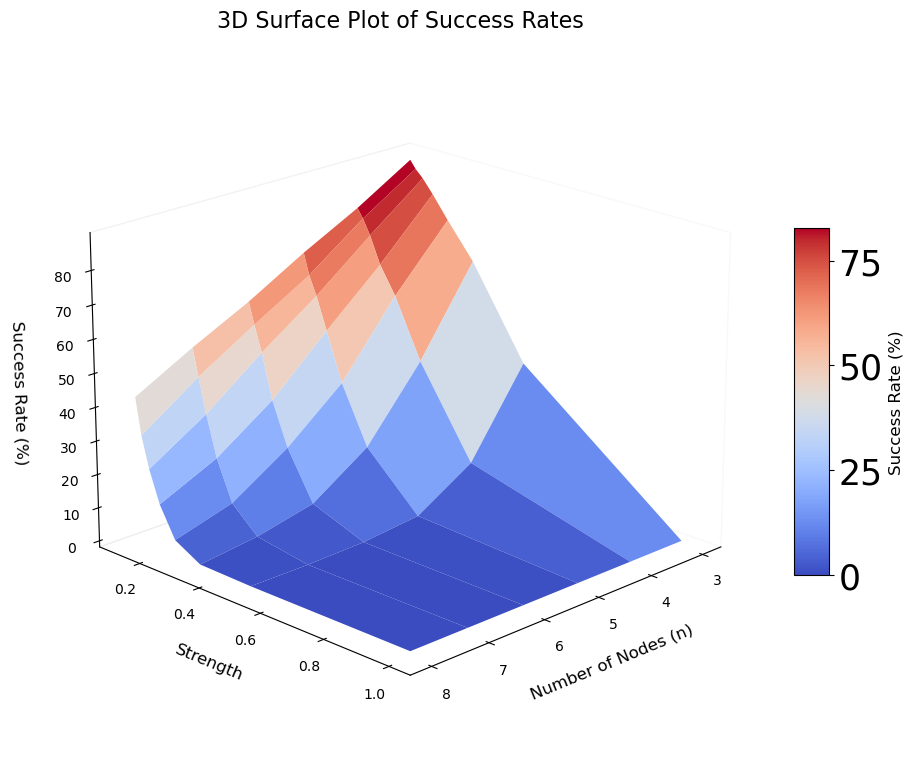

In [53]:

# Example data
n = np.array([3, 4, 5, 6, 7, 8])
strengths = np.array([1, 1/2, 1/3, 1/4, 1/5, 1/6, 1/7, 1/8])
success_rates = np.array(percent_success_by_strength)

# flip the success rates array
# success_rates = np.flip(success_rates, axis=0)

# Create meshgrid for n and strengths
N, Strengths = np.meshgrid(n, strengths)

# Create 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Surface plot with colormap and shading
surface = ax.plot_surface(N, Strengths, success_rates, cmap=cm.coolwarm, edgecolor='none', linewidth=0, antialiased=True)
surface.set_facecolor((1.0, 1.0, 1.0, 0))  # Transparent faces

# Lighting effect
ax.view_init(elev=25, azim=-120)  # Adjust viewing angle for better perspective

# Add color bar which maps values to colors
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Success Rate (%)', fontsize=12)

# Setting labels
ax.set_xlabel('Number of Nodes (n)', labelpad=10, fontsize=12)
ax.set_ylabel('Strength', labelpad=10, fontsize=12)
ax.set_zlabel('Success Rate (%)', labelpad=10, fontsize=12)

# Set title
ax.set_title('3D Surface Plot of Success Rates', pad=20, fontsize=16)

# Enhance tick labels size
ax.tick_params(axis='both', which='major', labelsize=10)



# Remove gridlines and background to make it cleaner
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.grid(False)

# Rotate the plot
ax.view_init(elev=20, azim=45)  # Set the elevation and azimuth angles

# Show plot
plt.savefig('multiplex-prop-pos-3d.png', dpi=60)
plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

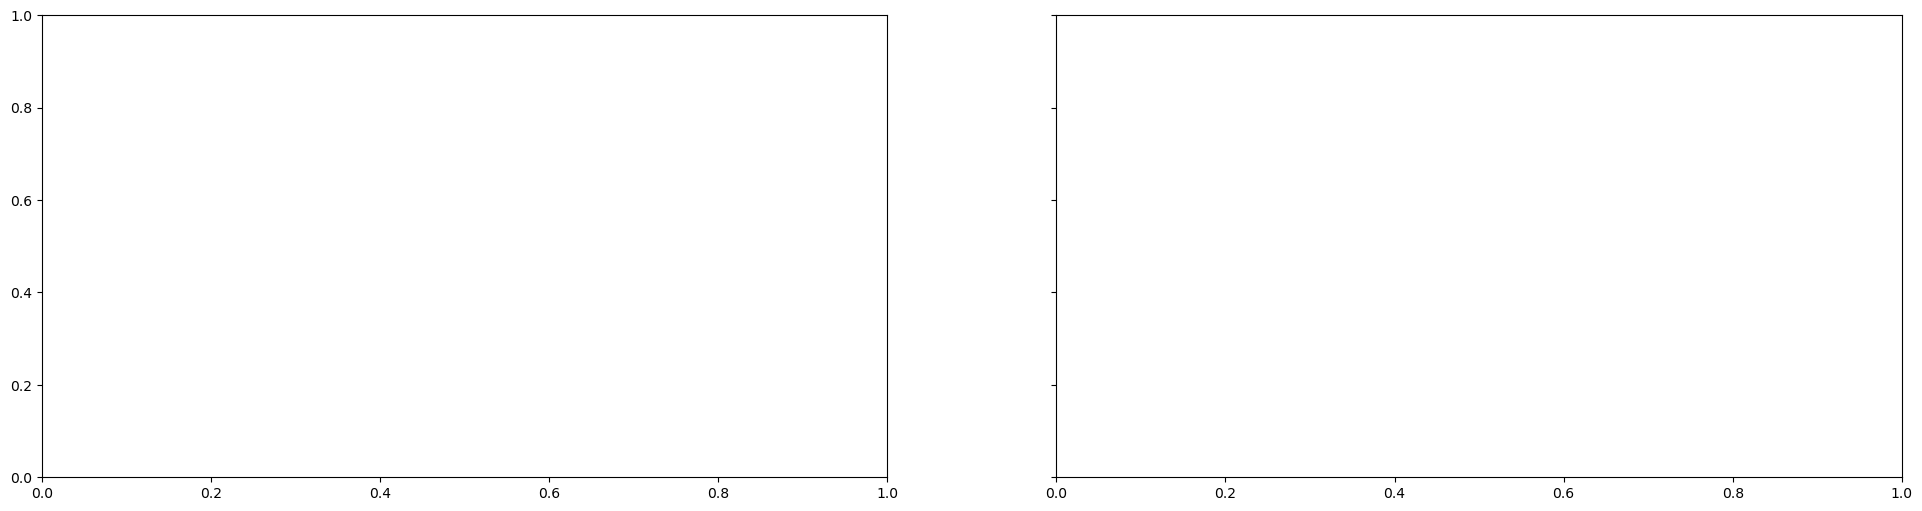

In [31]:
def plot_for_strength_4(ax, n_list, iterations, kappa):
    # Example code for strength = 4
    # Replace with actual plotting code specific to strength = 4
    condition_help_list = []
    p_matrix_total_list = []
    false_negative_list = []
    strength = 4

    for n in n_list:
        condition_true_count = 0
        total_count = 0
        false_positive = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n) * strength
            # threshold = strength * 0.2
            # G2[abs(G2) < threshold] = 0
            np.fill_diagonal(G2, 1)
            
            G = kappa * G1 + (1 - kappa) * G2
            result1 = check_p(G1)
            result2 = check_p(G2)
            result = check_p(G)

            lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
            lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
            condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * lambda_max_G1))

            # Check the conditions for unique NEs
            layer1_NE = result1 & (not result2)
            layer2_NE = (not result1) & result2
        
            if layer1_NE or layer2_NE:
                if not result:
                    total_count += 1
                    # Check condition for the matrices here
                    if condition:
                        condition_true_count += 1
            # counting false predictions
            if result:
                # total_count_all += 1
                if condition:
                    false_positive += 1

        condition_true_counts.append(condition_true_count)
        total_counts.append(total_count)
        false_positive_list.append(false_positive)

    width = 0.4
    x = np.arange(len(n_list))
    bar1 = ax.bar(x, condition_help_list, width, color='plum')
    bar2 = ax.bar(x + width/2, p_matrix_total_list, width, color='indigo')
    bar3 = ax.bar(x - width/2, false_negative_list, width, color='deeppink')

    percent_success = [(ch / pt * 100) if pt else 0 for ch, pt in zip(condition_help_list, p_matrix_total_list)]
    line_plot, = ax.plot(x, percent_success, marker='o', color='skyblue')

    return bar1, bar2, bar3, line_plot

def plot_for_strength_0125(ax, n_list, iterations, kappa):
    # Example code for strength = 0.5
    # Replace with actual plotting code specific to strength = 0.5
    condition_help_list = []
    p_matrix_total_list = []
    false_negative_list = []
    strength = 0.125

    for n in n_list:
        condition_help_count = 0
        p_matrix_total_count = 0
        false_negative = 0

        for i in range(iterations):
            G1 = generate_matrix(n)
            G2 = generate_matrix(n) * strength
            G = kappa * G1 + (1 - kappa) * G2
            result = check_p(G)

            lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
            lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

            condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

            if condition & result:
                condition_help_count += 1
            if result:
                p_matrix_total_count += 1
            if condition & (not result):
                false_negative += 1
        
        condition_help_list.append(condition_help_count)
        p_matrix_total_list.append(p_matrix_total_count)
        false_negative_list.append(false_negative)

    width = 0.4
    x = np.arange(len(n_list))
    bar1 = ax.bar(x, condition_help_list, width, color='plum')
    bar2 = ax.bar(x + width/2, p_matrix_total_list, width, color='indigo')
    bar3 = ax.bar(x - width/2, false_negative_list, width, color='deeppink')

    percent_success = [(ch / pt * 100) if pt else 0 for ch, pt in zip(condition_help_list, p_matrix_total_list)]
    line_plot, = ax.plot(x, percent_success, marker='o', color='skyblue')

    return bar1, bar2, bar3, line_plot

# Parameters
iterations = 5000
n_list = [3, 4, 5, 6, 7, 8, 9, 10]
kappa = 0.5

# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(24, 6), sharey=True)

# Plot for strength = 4
bar1, bar2, bar3, line_plot = plot_for_strength_4(axs[0], n_list, iterations, kappa)
axs[0].legend([bar1, bar2, bar3, line_plot], 
              ['Successfully detected by Proposition 3', 
               'Multiplex networks without unique NE and a layer that has a unique NE', 
               'False predictions',
               'Success Rate'], 
              loc='best')

# Plot for strength = 0.5
bar1, bar2, bar3, line_plot = plot_for_strength_0125(axs[1], n_list, iterations, kappa)
axs[1].legend([bar1, bar2, bar3, line_plot], 
              ['Successfully detected by Proposition 3', 
               'Multiplex networks without unique NE and a layer that has a unique NE', 
               'False predictions',
               'Success Rate'], 
              loc='best')

# Adjust layout
plt.tight_layout()
plt.show()


In [15]:
# # MODIFIED VERSION --> UNTIL A CERTAIN NUMBER OF DESIRED INSTANCES ARE FOUND    

# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5
# strength_list = [2, 4, 8, 10]

# # Prepare the figure for 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# axs = axs.flatten()  # Flatten the axs array for easy indexing

# # Bar colors
# bar_color1 = 'plum'
# bar_color2 = 'indigo'

# # Lists to store success and false prediction rates for each strength
# percent_success_by_strength = [[] for _ in strength_list]
# percent_false_by_strength = [[] for _ in strength_list]

# # Loop through each strength value
# for idx, strength in enumerate(strength_list):
#     condition_true_counts = []
#     total_counts = []
#     false_positive_list = []

#     for n in n_list:
#         condition_true_count = 0
#         total_count = 0
#         false_positive = 0

#         # Continue until we have 1000 instances for this n and strength
#         while total_count < 1000:
#             G1 = generate_matrix(n)
#             G2 = generate_matrix(n) * strength
#             np.fill_diagonal(G2, 1)

#             G = kappa * G1 + (1 - kappa) * G2
#             result1 = check_p(G1)
#             result2 = check_p(G2)
#             result = check_p(G)

#             lambda_min_G2 = np.min(np.linalg.eigvals(G2 - np.eye(n)))
#             lambda_max_G1 = np.max(np.linalg.eigvals(G1 - np.eye(n)))
#             condition = abs(lambda_min_G2) >= (1 / (1 - kappa)) * (1 + (kappa * lambda_max_G1))

#             if (result1 & (not result2)) or ((not result1) & result2):
#                 if not result:
#                     total_count += 1
#                     if condition:
#                         condition_true_count += 1

#             if result:
#                 if condition:
#                     false_positive += 1

#         condition_true_counts.append(condition_true_count)
#         total_counts.append(total_count)
#         false_positive_list.append(false_positive)

#     # Calculate percentages for each 'n'
#     for total_count, condition_true_count, false_positive in zip(total_counts, condition_true_counts, false_positive_list):
#         success_rate = (condition_true_count / total_count * 100) if total_count else 0
#         false_rate = (false_positive / total_count * 100) if total_count else 0
#         percent_success_by_strength[idx].append(success_rate)
#         percent_false_by_strength[idx].append(false_rate)

#     # Plotting for this strength value
#     ax = axs[idx]
#     width = 0.4
#     x = np.arange(len(n_list))

#     ax.bar(x + width/2, total_counts, width, color=bar_color2)
#     ax.bar(x, condition_true_counts, width, color=bar_color1)
#     ax.bar(x - width/2, false_positive_list, width, color='deeppink')

#     ax.set_xlabel('Number of Nodes (n)')
#     ax.set_ylabel('Count')
#     ax.set_title(f'Relative Strength of Edges = {strength}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(n_list)

# # Add legend and adjust layout
# labels = ['Multiplex networks without unique NE and a layer that has a unique NE', 'Successfully detected by Proposition 9', 'False predictions']
# fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)
# plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# # plt.savefig('multiplex-prop-neg.png', dpi=600)
# plt.show()


In [16]:
def generate_negative_matrix(n):
    # Generate a random matrix with values between -1 and 0
    matrix = np.random.uniform(-1, 0, (n, n))
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

def is_m_matrix(matrix):
    B = matrix - np.eye(n)
    rho = np.max(np.abs(np.linalg.eigvals(-B)))
    return rho < 1

def is_PD_matrix(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)

def generate_symmetric(n):
    # Generate a random matrix with values between -1 and 1
    A = np.random.uniform(-1, 1, (n, n))
    matrix = (A + A.T) / 2
    # Set diagonal elements to 1
    np.fill_diagonal(matrix, 1)
    
    return matrix

def calculate_2_norm(matrix):
    # Perform Singular Value Decomposition
    U, s, V = np.linalg.svd(matrix)
    
    # The 2-norm is the largest singular value
    return max(s)

In [17]:
# iterations = 10000
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5

# # For M-matrix
# for n in n_list:
#     for i in range(iterations):
#         G1 = generate_negative_matrix(n)
#         G2 = generate_symmetric(n)
#         G = kappa * G1 + (1 - kappa) * G2
#         result1 = check_p(G1)
#         result2 = check_p(G2)
#         result = check_p(G)
        
#         lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))
#         lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))

#         if result1: # G1 is a P-matrix
#             if is_m_matrix(G1): # G1 is an M-matrix
#                 condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1
#                 if condition & (not result): # condition is satisfied but G is not a P-matrix (should not happen!)
#                     print("\nwelp!")

In [18]:
# iterations = 10000
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5

# # For PD matrix
# for n in n_list:
#     for i in range(iterations):
#         G1 = generate_symmetric(n)
#         G2 = generate_symmetric(n)
#         G = kappa * G1 + (1 - kappa) * G2

#         result1 = is_PD_matrix(G1) # first layer has a unique NE
#         result2 = is_PD_matrix(G2) # second layer has a unique NE
#         result = is_PD_matrix(G) # multiplex has a unique NE

#         lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
#         lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

#         condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

#         if result1 & condition & (not result): # first layer has a unique NE and condition is satisfied but multiplex does not have a unique NE (should not happen!)
#             print("welp! n: ", n)
#             break
#             # print(G1)
#             # print("\n")
#             # print(G2)
#             # print("\n")
#             # print(G)
#             # print("lambda_max_G1: ", lambda_max_G1)
#             # print("lambda_max_G2: ", lambda_max_G2)
#             # print("condition: ", condition)

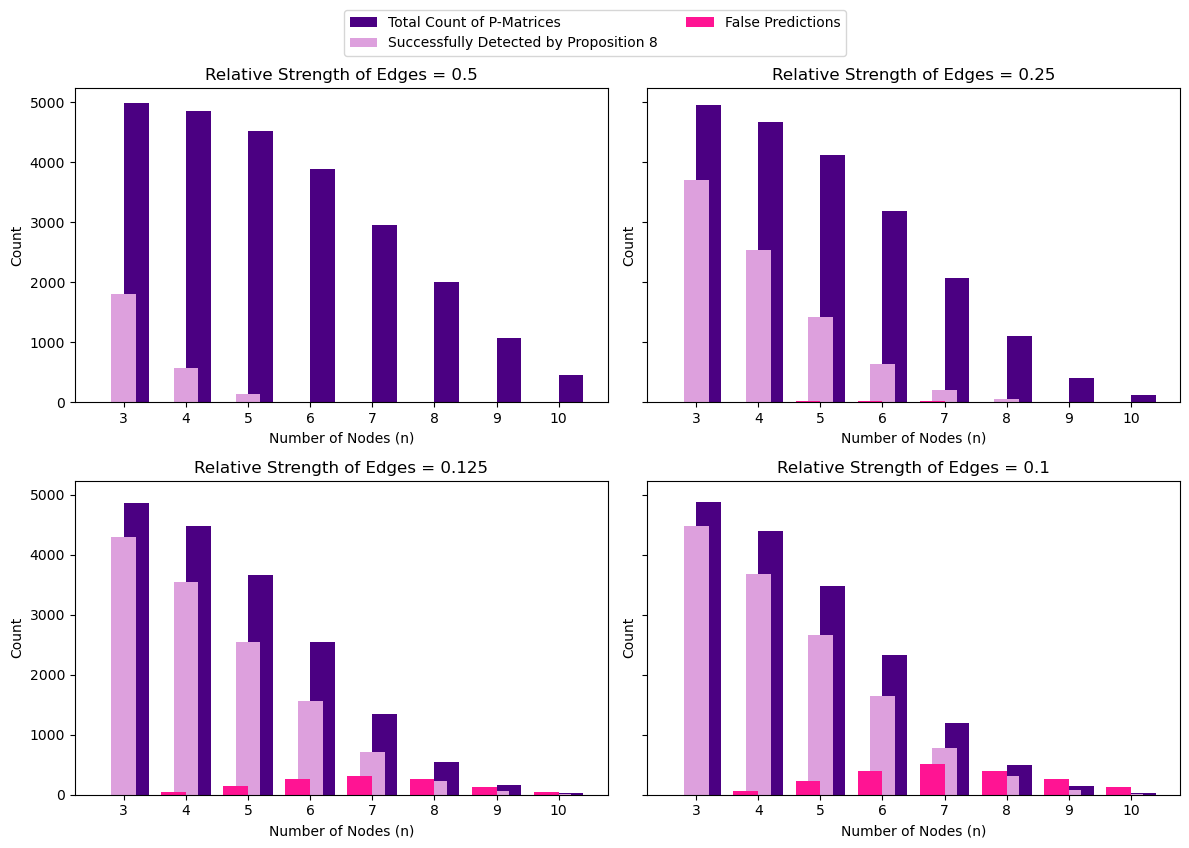

In [23]:
# iterations = 5000
# n_list = [3, 4, 5, 6, 7, 8, 9, 10]
# kappa = 0.5
# condition_help_list = []
# p_matrix_total_list = []
# strength_list = [0.5, 0.25, 0.125, 0.1]

# # Prepare the figure for 2x2 subplots
# fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
# axs = axs.flatten()  # Flatten the axs array for easy indexing

# # Bar colors
# bar_color1 = 'plum'
# bar_color2 = 'indigo'

# for idx, strength in enumerate(strength_list):
#     condition_help_list = []
#     p_matrix_total_list = []
#     false_negative_list = []

#     for n in n_list:
#         condition_help_count = 0
#         p_matrix_total_count = 0
#         false_negative = 0

#         for i in range(iterations):
#             G1 = generate_matrix(n)
#             G2 = generate_matrix(n) * strength
#             G = kappa * G1 + (1 - kappa) * G2
#             result = check_p(G)

#             lambda_min_G1 = np.min(np.linalg.eigvals(G1-np.eye(n)))
#             lambda_max_G2 = np.max(np.linalg.eigvals(G2-np.eye(n)))

#             condition = lambda_max_G2 < ((2 * kappa - 1) / (1 - kappa)) + (kappa/ (1-kappa)) * lambda_min_G1

#             if condition & result:
#                 condition_help_count += 1
#             if result:
#                 p_matrix_total_count += 1
#             if condition & (not result):
#                 false_negative += 1
        
#         condition_help_list.append(condition_help_count)
#         p_matrix_total_list.append(p_matrix_total_count)
#         false_negative_list.append(false_negative)

#     # Plotting for this strength value
#     ax = axs[idx]
#     width = 0.4
#     x = np.arange(len(n_list))

#     ax.bar(x + width/2, p_matrix_total_list, width, color=bar_color2)
#     ax.bar(x, condition_help_list, width, color=bar_color1)
#     ax.bar(x - width/2, false_negative_list, width, color='deeppink')

#     ax.set_xlabel('Number of Nodes (n)')
#     ax.set_ylabel('Count')
#     ax.set_title(f'Relative Strength of Edges = {strength}')
#     ax.set_xticks(x)
#     ax.set_xticklabels(n_list)

#     # for i, v in enumerate(percentages):
#     #     ax.text(i, v + 5, f'{v:.1f}%', ha='center')

# # Adding a single legend at the upper center
# labels = ['Total Count of P-Matrices', 'Successfully Detected by Proposition 8', 'False Predictions']
# fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=2)

# plt.tight_layout(rect=[0, 0.1, 1, 0.9])
# # Uncomment to save the figure
# plt.savefig('multiplex-prop-pos.png', dpi=600)
# plt.show()

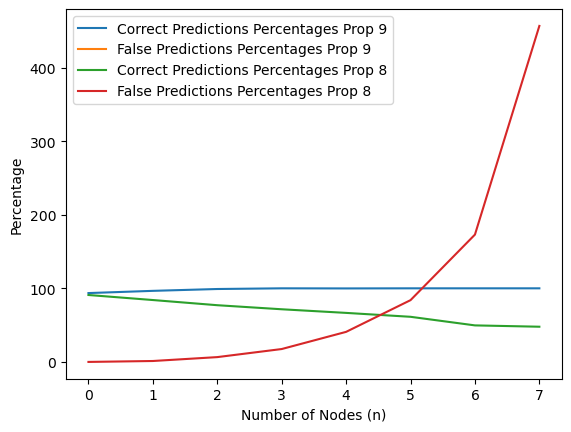

In [6]:
# # Creating a figure and axis
# fig, ax = plt.subplots()

# # Plotting data
# ax.plot(percentages_prop9, label='Correct Predictions Percentages Prop 9')
# ax.plot(false_positive_percentages_prop9, label='False Predictions Percentages Prop 9')
# ax.plot(percentages_prop8, label='Correct Predictions Percentages Prop 8')
# ax.plot(false_positive_percentages_prop8, label='False Predictions Percentages Prop 8')

# # Adding titles and labels
# # ax.set_title('Comparison of Percentages')
# ax.set_xlabel('Number of Nodes (n)')
# ax.set_ylabel('Percentage')

# # Adding a legend
# ax.legend()

# # Displaying the plot
# plt.show()


# Max eigval experiments


In [34]:
#  define a function to compute the maximum eigenvalue of a matrix
def max_eigenvalue(matrix):
    return np.max(np.linalg.eigvals(matrix))

# define a function to generate sparse matrices of size n
def generate_sparse_matrix(n, lower, upper, threshold):
    # generate a random matrix with values between lower and upper
    matrix = np.random.uniform(lower, upper, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)
    # set all elements below threshold to 0
    matrix[abs(matrix) < threshold] = 0

    return matrix

# define a function to generate random matrices of size n
def generate_random_matrix(n):
    # generate a random matrix with values between -1 and 1
    matrix = np.random.uniform(-1, 1, (n, n))
    # set diagonal elements to 0
    np.fill_diagonal(matrix, 0)

    return matrix

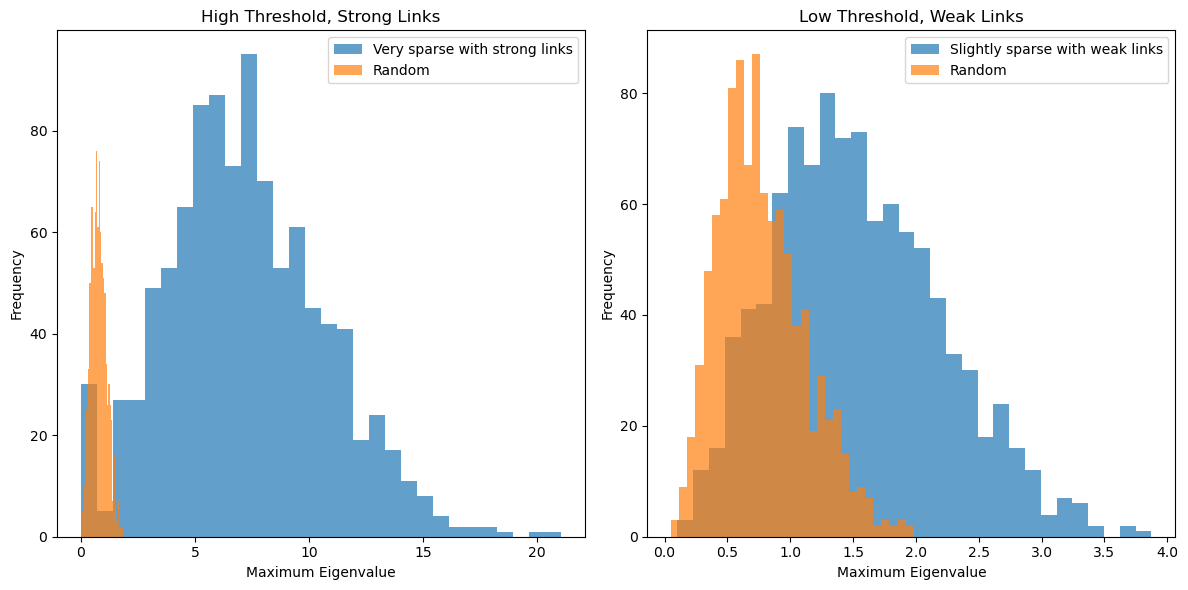

In [37]:
# Define matrix size
n = 5
num_instances = 1000

# Initialize lists to store maximum eigenvalues
max_eigenvalues_sparse_strong = []
max_eigenvalues_random_strong = []
max_eigenvalues_sparse_weak = []
max_eigenvalues_random_weak = []

for _ in range(num_instances):
    # High threshold (very sparse matrix) and strong links (high values of lower and upper)
    sparse_matrix_strong = generate_sparse_matrix(n, -10, 10, 4)
    random_matrix_strong = generate_random_matrix(n)

    # Low threshold (not very sparse) and not very strong links
    sparse_matrix_weak = generate_sparse_matrix(n, -2, 2, 0.1)
    random_matrix_weak = generate_random_matrix(n)

    # Computing max eigenvalues
    max_eigenvalues_sparse_strong.append(max_eigenvalue(sparse_matrix_strong).real)
    max_eigenvalues_random_strong.append(max_eigenvalue(random_matrix_strong).real)
    max_eigenvalues_sparse_weak.append(max_eigenvalue(sparse_matrix_weak).real)
    max_eigenvalues_random_weak.append(max_eigenvalue(random_matrix_weak).real)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(max_eigenvalues_sparse_strong, bins=30, alpha=0.7, label='Very sparse with strong links')
plt.hist(max_eigenvalues_random_strong, bins=30, alpha=0.7, label='Random')
plt.title('High Threshold, Strong Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(max_eigenvalues_sparse_weak, bins=30, alpha=0.7, label='Slightly sparse with weak links')
plt.hist(max_eigenvalues_random_weak, bins=30, alpha=0.7, label='Random')
plt.title('Low Threshold, Weak Links')
plt.xlabel('Maximum Eigenvalue')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Other experiments

/var/folders/hs/y116vr4j4yg5fcthw_l99c5r0000gn/T/ipykernel_4548/3928030750.py:37: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G).todense()


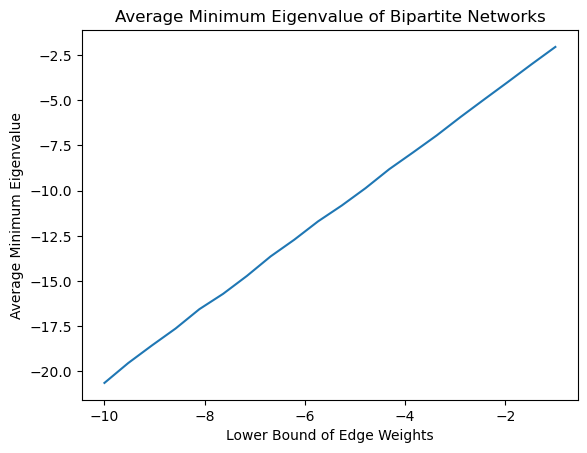

In [45]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def create_bipartite_network(n1, n2, lower, upper):
    # Create an empty bipartite graph
    G = nx.Graph()

    # Add nodes to the graph
    G.add_nodes_from(range(n1), bipartite=0)
    G.add_nodes_from(range(n1, n1 + n2), bipartite=1)

    # Generate edge weights from a uniform distribution between lower and upper
    weights = np.random.uniform(lower, upper, (n1, n2))

    # Add edges to the graph with the generated weights
    for i in range(n1):
        for j in range(n2):
            G.add_edge(i, n1 + j, weight=weights[i, j])

    return G

def min_eigenvalue(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.min(eigenvalues)

def average_min_eigenvalue_experiment(n1, n2, iterations, lower_range, upper_range):
    avg_min_eigenvalues = []

    # Iterate over the range of lower and upper bounds
    for lower, upper in zip(lower_range, upper_range):
        min_eigvals = []

        # Create instances of bipartite networks and compute their min eigenvalue
        for _ in range(iterations):
            G = create_bipartite_network(n1, n2, lower, upper)
            adj_matrix = nx.adjacency_matrix(G).todense()
            min_eigval = min_eigenvalue(adj_matrix)
            min_eigvals.append(min_eigval)

        # Calculate and store the average minimum eigenvalue
        avg_min_eigenvalues.append(np.mean(min_eigvals))

    return avg_min_eigenvalues

# Parameters
n1, n2 = 5, 5  # number of nodes in each part of the bipartite network
iterations = 1000
lower_range = np.linspace(-1, -10, 20)  # Lower bounds from -1 to -10
upper_range = np.linspace(1, 10, 20)    # Upper bounds from 1 to 10

# Run the experiment
avg_min_eigvals = average_min_eigenvalue_experiment(n1, n2, iterations, lower_range, upper_range)

# Plotting
plt.plot(lower_range, avg_min_eigvals)
plt.xlabel('Lower Bound of Edge Weights')
plt.ylabel('Average Minimum Eigenvalue')
plt.title('Average Minimum Eigenvalue of Bipartite Networks')
plt.show()
